# Custom Objective and Evaluation Functions

This demo was adapted from **[xgboost's custom metric tutorial](https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html)**.  We demonstrate how to use a custom objective and a custom evaluation function using an xgboost trainer.

This function differs from `xgb_trainer` by exposing the low-level xgboost python api, `train`.  

In [12]:
# nuclio: ignore
import nuclio

In [13]:
from os import path
import numpy as np
from numpy.random import randint, randn, seed
import pandas as pd
from xgboost import DMatrix, train
import matplotlib.pyplot as plt
from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem
from mlrun.artifacts import PlotArtifact
from mlrun.mlutils import get_splits, get_sample

from cloudpickle import dumps

from typing import (Tuple, Dict, List, Union, Callable)

seed(seed=1994)

## UNCOMMENT THIS LINE TO TEST CALCULATED VALUES
DEBUG_ERROR = 0 # this will be added to the custom eval function--set it to some value like 999 

### generate data with outliers

In [14]:
def gen_outliers(context: MLClientCtx, nrows=4096, feats=16, 
                 outs=64, omax=10_000, labels_col="labels",
                 header=[], label_type="int32", key="xgb-outs",
                 local_path="xgb_custom"):
    """simulate data with outliers
    
    :param context:    the function's execution context
    :param nrows:      (4096) number of data points
    :param feats:      (16) number of features
    :param outs:       (64) number of outliers
    :param omax:       (10_100) max value of outliers
    :param labels_col: (labels) name of labels column
    :param header:     () header for dataset, will default to
                       `feat_`
    :param label_type: (int32) data type for the label column
    :param key:        key of datset in artifact store
    :param local_path: path in artifact store where data will be
                       serialized
    """
    x = randn(nrows, feats)
    y = randn(nrows)
    y += np.abs(np.min(y))

    for i in range(0, outs):
        ind = randint(0, len(y)-1)
        y[ind] += randint(0, omax)
    
    if not header:
        header = [f"feat_{j}" for j in range(feats)]
        header.append(labels_col)

    data = pd.DataFrame(data=np.concatenate((x,y.reshape(-1,1)),axis=-1),
                        columns=header)
    data = data.astype({labels_col: label_type})
    
    context.log_dataset(key, df=data, local_path=local_path)

## custom objective and eval

The following code was adapted from xgboost's documentation **[Custom Objective and Evaluation Metric](https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html?highlight=tree_method#custom-objective-and-evaluation-metric)**.

In [15]:
def gradient(predt: np.ndarray, dtrain: DMatrix) -> np.ndarray:
    """gradient of squared log error"""
    y = dtrain.get_label()
    return (np.log1p(predt) - np.log1p(y)) / (predt + 1)


def hessian(predt: np.ndarray, dtrain: DMatrix) -> np.ndarray:
    """hessian of squared log error"""
    y = dtrain.get_label()
    return ((-np.log1p(predt) + np.log1p(y) + 1) /
            np.power(predt + 1, 2))


def squared_log(predt: np.ndarray, dtrain: DMatrix) -> Tuple[np.ndarray,
                                                             np.ndarray]:
    """squared log error objective

    simplified version for RMSLE used as objective function
    """
    predt[predt < -1] = -1 + 1e-6
    grad = gradient(predt, dtrain)
    hess = hessian(predt, dtrain)
    return grad, hess

def rmsle(predt: np.ndarray, dtrain: DMatrix) -> Tuple[str, float]:
    """ Root mean squared log error metric.
    """
    y = dtrain.get_label()
    predt[predt < -1] = -1 + 1e-6
    elements = np.power(np.log1p(y) - np.log1p(predt), 2)
    return "my_rmsle", float(np.sqrt(np.sum(elements) / len(y))) + DEBUG_ERROR

## learning curves

In [16]:
def learning_curves(
    context: MLClientCtx,
    results: dict,
    figsz: Tuple[int,int]=(10,10),
    plots_dest: str = "plots"
) -> None:
    """plot xgb learning curves
    
    this will also log a model's learning curves
    """
    plt.clf()
    plt.figure(figsize=figsz)
    plt.plot(results["train"]["my_rmsle"], label="train-my-rmsle")
    plt.plot(results["valid"]["my_rmsle"], label="valid-my-rmsle")
    plt.title(f"learning curves")
    plt.legend()
 
    context.log_artifact(
        PlotArtifact(f"learning-curves", body=plt.gcf()),
        local_path=f"{plots_dest}/learning-curves.html")

## fit

In [17]:
def fit(
    context: MLClientCtx,
    dataset: DataItem,
    num_boost_round: int = 10,
    evals: List[Tuple[DMatrix, str]] = [],
    obj: Union[Callable, str] = "",
    feval: Union[Callable, str] = None,
    maximize: bool = False,
    early_stopping_rounds: int = None,
    evals_result: dict = {},
    verbose_eval: bool = True,
    xgb_model: DataItem = None,
    callbacks: List[Callable] = [],
    label_column: str = "labels",
    encode_cols: dict = {},
    sample: int = -1,
    test_size: float = 0.25,
    valid_size: float = 0.75,
    random_state: int = 1994,
    models_dest: str = "models",
    plots_dest: str = "plots",
    file_ext: str = "csv",
    test_set_key: str = "test-set",
    gpus: bool = False
) -> None:
    """low level xgboost train api
    
    for the xgboost `train` params see:
    https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.train

    Note:  the first parameter of xgboost's `train` method is a dict of parameters
           supplied to the booster (engine).  To modify one of those simply
           add a task parameter (when running you supply an mlrun NewTask) with the
           prefix "XGB_". So for example, to set the 'tree_method' parameter to 'approx',
           add {"XGB_tree_method":"approx"} to the task params key.
    
    :param context:           the function context
    :param dataset:           the full data set, train, valid and test will be extracted and
                              each converted to a DMatrix for input to xgboost's `train`
    :param label_column:      ground-truth (y) labels
    :param encode_cols:       dictionary of names and prefixes for columns that are
                              to hot be encoded.
    :param sample:            Selects the first n rows, or select a sample
                              starting from the first. If negative <-1, select
                              a random sample
    :param test_size:         (0.05) test set size
    :param valid_size:        (0.75) Once the test set has been removed the
                              training set gets this proportion.
    :param random_state:      (1) sklearn rng seed
    :param models_dest:       destination subfolder for model artifacts
    :param plots_dest:        destination subfolder for plot artifacts
    :param file_ext:          format for test_set_key hold out data
    :param test_set_key:      (test-set), key of held out data in artifact store
    :param gpus:              (False), run on gpus
    """
    raw, labels, header = get_sample(dataset, sample, label_column)
    
    # hot-encode
    if encode_cols:
        raw = pd.get_dummies(raw, 
                             columns=list(encode_cols.keys()), 
                             prefix=list(encode_cols.values()), 
                             drop_first=True)
    
    # split the sample into train validate, test and calibration sets:
    (xtrain, ytrain), (xvalid, yvalid), (xtest, ytest) = \
        get_splits(raw, labels, 3, test_size, valid_size, random_state)
    
    # save test data as regular dataframe as it may be used by other process
    context.log_dataset(test_set_key, df=pd.concat([xtest, ytest], axis=1),
                        format=file_ext, index=False)
    
    # convert to xgboost DMatrix (todo - dask, gpu)
    dtrain = DMatrix(xtrain, label=ytrain)
    dvalid = DMatrix(xvalid, label=yvalid)
    
    boost_params = {
        "tree_method": "gpu_hist" if gpus else "hist", 
        "seed": random_state,
        "disable_default_eval_metric": 1,
        "objective": "reg:squaredlogerror",
        "eval_metric": "rmsle"}

    # enable user to customize `booster param` parameters
    for k, v in context.parameters.items():
        if k.startswith('XGB_'):
            boost_params[k[4:]] = v
    
    # collect learning curves / training history
    results = dict()
    
    booster = train(
        boost_params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        evals=[(dtrain, "train"), (dvalid, "valid")],
        evals_result=results,
        obj=squared_log,
        feval=rmsle,
        maximize=maximize,
        early_stopping_rounds=early_stopping_rounds,
        verbose_eval=verbose_eval,
        # xgb_model=xgb_model,
        # callbacks: List[Callable] = []
    )
    
    context.log_model("model", 
                      body=dumps(booster),
                      model_file = "model.pkl",
                      artifact_path='/User/artifacts/tttt')
    
    learning_curves(context, results)

In [18]:
# nuclio: end-code

### run locally

In [19]:
from mlrun import NewTask, run_local

In [20]:
gen_outs_tsk = NewTask(name='gen_outliers',
                       handler=gen_outliers, 
                       params={'nrows': 8192, 'label_type': 'float'})

outliers_run = run_local(gen_outs_tsk)

[mlrun] 2020-06-14 13:30:21,675 starting run gen_outliers uid=29ae7c944a184de881acc81206a92a48  -> http://mlrun-api:8080
[mlrun] 2020-06-14 13:30:22,141 log artifact xgb-outs at /User/artifacts/xgb_custom.csv, size: 2762858, db: Y



project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...06a92a48,0,Jun 14 13:30:21,completed,gen_outliers,v3io_user=adminkind=handlerowner=adminhost=jupyter-7b44c8d958-kklf7,,nrows=8192label_type=float,,xgb-outs


to track results use .show() or .logs() or in CLI: 
!mlrun get run 29ae7c944a184de881acc81206a92a48 --project default , !mlrun logs 29ae7c944a184de881acc81206a92a48 --project default
[mlrun] 2020-06-14 13:30:22,218 run executed, status=completed


[mlrun] 2020-06-14 13:30:23,011 starting run fit model uid=489d2d26007e444cb81ffe7b6bc9d4a2  -> http://mlrun-api:8080
[mlrun] 2020-06-14 13:30:23,405 log artifact test-set at /User/artifacts/test-set.csv, size: 689366, db: Y
[mlrun] 2020-06-14 13:30:23,545 log artifact model at /User/artifacts/tttt/, size: 17052, db: Y
[mlrun] 2020-06-14 13:30:23,712 log artifact learning-curves at /User/artifacts/plots/learning-curves.html, size: 31641, db: Y



project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...6bc9d4a2,0,Jun 14 13:30:23,completed,fit model,v3io_user=adminkind=handlerowner=adminhost=jupyter-7b44c8d958-kklf7,dataset,num_boost_round=40verbose_eval=FalseXGB_max_depth=2XGB_subsample=0.9,,test-setmodellearning-curves


to track results use .show() or .logs() or in CLI: 
!mlrun get run 489d2d26007e444cb81ffe7b6bc9d4a2 --project default , !mlrun logs 489d2d26007e444cb81ffe7b6bc9d4a2 --project default
[mlrun] 2020-06-14 13:30:23,790 run executed, status=completed


<Figure size 432x288 with 0 Axes>

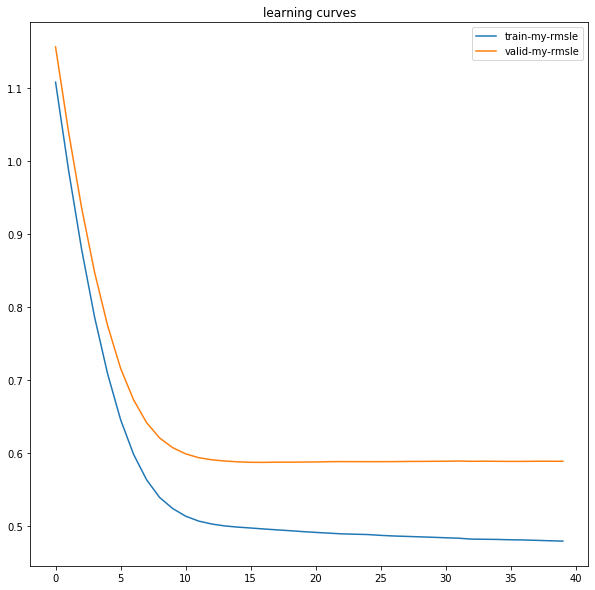

In [21]:
# THIS IS SETUP SO THAT YOU CAN COMPARE THE RESULTS AND SEE THAT THEY ARE EXACT.  
# UNCOMMENT LINE `DEBUG_ERROR` AT TOP OF THIS NOTEBOOK TO TEST THAT THESE ARE 
# TRULY CALCULATED VALUES

fit_tsk = NewTask(
    name='fit model', 
    handler=fit,
    params={"num_boost_round" : 40, 
            "verbose_eval"    : False,
            "XGB_max_depth"   : 2,
            "XGB_subsample"   : 0.9}
)

fit_run = run_local(fit_tsk, inputs={"dataset":outliers_run.outputs["xgb-outs"]})

# export

In [23]:
from mlrun import code_to_function
from mlrun.platforms.other import auto_mount

gpus = False

# create job function object from notebook code
fn_params = {
    "name"        : "xgb_custom",
    "handler"     : "fit",
    "kind"        : "job",
    "image"       : "mlrun/ml-models" if not gpus else "mlrun/ml-models-gpu",
    "description" : "train an xgboost model using the low-level api",
    "categories"  : ["analysis"],
    "labels"      : {"author": "yjb"}
}

xgb_fn = code_to_function(**fn_params)

xgb_fn.export("function.yaml")
xgb_fn.apply(auto_mount())

[mlrun] 2020-06-14 13:30:50,033 function spec saved to path: function.yaml
